Perform CIFAR10 classification using Neural Netwroks and Convolutional Neural Networks.

1) Use 10 iterations for training


2) Show the training loss for both networks on the same plot


3) Compare the test loss and accuracy.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary


In [2]:
# CIFAR10
def cifar10(batch_sz, path='./datasets'):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(32, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = CIFAR10(root=path, train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz,
                                               shuffle=True, pin_memory=True)

    # Test dataset
    test_data = CIFAR10(root=path, train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes


In [3]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, test_loader, _=cifar10(batch_sz) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


In [5]:
class CNN(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 10, 5, 1)
      self.conv2 = nn.Conv2d(10, 50, 5, 1)
      self.linear1 = nn.Linear(5 * 5 * 50, 100)
      self.linear2 = nn.Linear(100, 10)
      self.maxpool = nn.MaxPool2d((2, 2))

  def forward(self, x):
    #feature extracter
    x = self.conv1(x)
    x = F.relu(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.maxpool(x)

    x = x.view(-1, 5*5*50)

    #classifier
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    return(x)

device = torch.device("cuda:0")
net = CNN()
net = net.to(device)

epochs = 10
lr = 0.1
mm = 0.5

ls = []
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
schduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9, verbose = False)
loss_fn = nn.CrossEntropyLoss()

for i in range(epochs):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].to(device),batch[1].to(device)
    logits = net(X)
    loss = loss_fn(logits, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  schduler.step()
  ls.append(total_loss)


[1534.6963685750961, 1248.1029510498047, 1128.7602396011353, 1052.7759202718735, 991.1123840808868, 944.7999786138535, 907.3932639360428, 861.0329834222794, 833.2556660175323, 809.2068546414375]


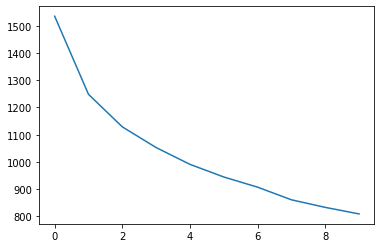

In [11]:
plt.plot(ls)
print(ls)

In [ ]:
class NN(nn.Module):
  def __init__(self, ni, nh, no):
    super().__init__()
    self.l1 = nn.Linear(ni, nh)
    self.l2 = nn.Linear(nh, no)

  def forward(self, x):
    x = x.view(-1, 32*32*3)
    x = self.l1(x)
    x = torch.sigmoid(x)
    x = self.l2(x)
    return x

ni = 32*32*3
nh = 100
no = 10

lr1 = 0.5
mm1 = 0.5
epochs1 = 10

ls1 = []

device1 = torch.device("cuda:0")
net1 = NN(ni, nh, no)
net1 = net1.to(device1)

optimizer = optim.SGD(net1.parameters(), lr = lr1, momentum = mm1)

loss_fn = nn.CrossEntropyLoss()
 
for i in range(epochs1):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].to(device1), batch[1].to(device1)
    #print(y.shape)
    logits = net1(X)
    #print(logits.shape)
    loss = loss_fn(logits, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  ls1.append(total_loss)


The loss of NN:
[1566.5104293823242, 1482.7908771038055, 1472.4085911512375, 1463.3001182079315, 1450.4732344150543, 1433.8853203058243, 1420.4951043128967, 1421.7915414571762, 1408.0351996421814, 1405.3462368249893]
The loss of CNN:
[1534.6963685750961, 1248.1029510498047, 1128.7602396011353, 1052.7759202718735, 991.1123840808868, 944.7999786138535, 907.3932639360428, 861.0329834222794, 833.2556660175323, 809.2068546414375]


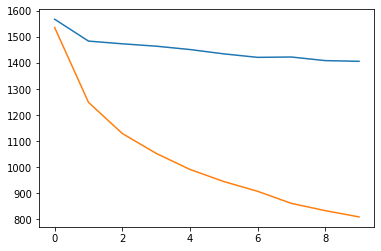

In [16]:
print("The loss of NN:")
print(ls1)
plt.plot(ls1)
print("The loss of CNN:")
print(ls)
plt.plot(ls)

From the picture above we can conclude the loss of CNN is much better than NN.

In [17]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 33.8 MB/s 


0.32165605
0.66769505


<Figure size 432x288 with 0 Axes>

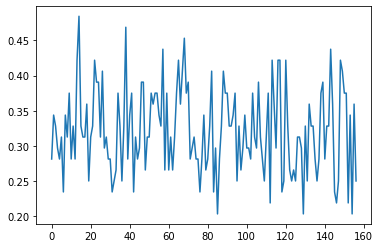

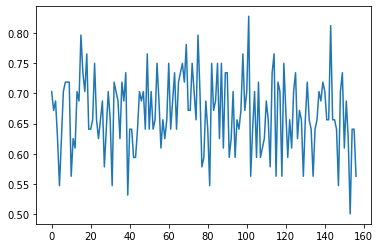

<Figure size 432x288 with 0 Axes>

In [18]:
import torchmetrics as tm
acc1 = []
accuracy1 = tm.Accuracy()
for batch in test_loader:
  X, y = batch[0].to(device), batch[1].to(device)
  logits = net1(X)
  yhat = torch.argmax(logits, axis = 1)
  a = accuracy1(yhat.to("cpu"), y.to("cpu"))
  acc1.append(a)

plt.plot(acc1)
print(np.mean(acc1))
plt.figure()
acc = []
accuracy = tm.Accuracy()
for batch in test_loader:
  X, y = batch[0].to(device), batch[1].to(device)
  logits = net(X)
  yhat = torch.argmax(logits, axis = 1)
  a = accuracy(yhat.to("cpu"), y.to("cpu"))
  acc.append(a)

plt.plot(acc)
print(np.mean(acc))
plt.figure()


From the pictures above we can see the accuracy of CNN is higher than NN.